Баданина Наталья ПМ3-1

Курсовая работа на тему "Разработка и построение рекомендательной системы"

Датасет с данными клиентов банка: https://www.kaggle.com/c/santander-product-recommendation/overview

Проблема: Under their current system, a small number of Santander’s customers receive many recommendations while many others rarely see any resulting in an uneven customer experience. 

Задача: Predict which products their existing customers will use in the next month based on their past behavior.

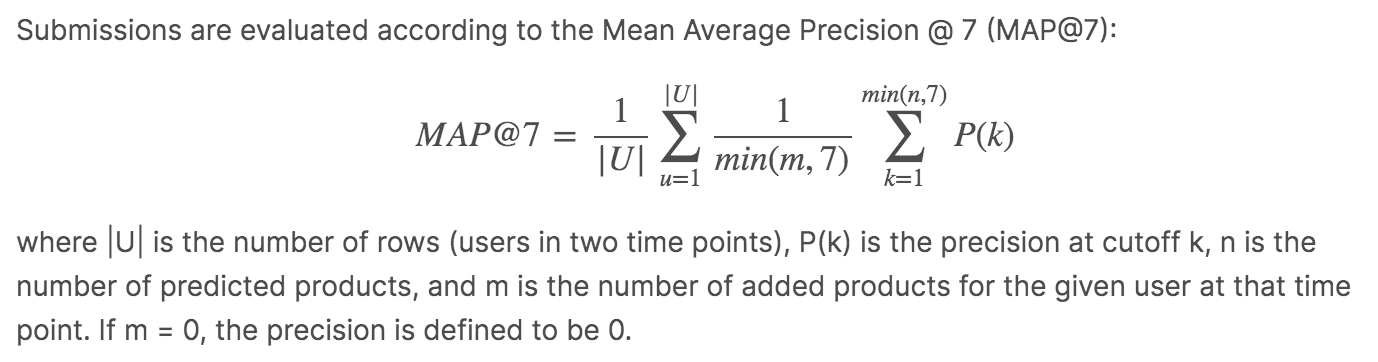

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
#для отображения графиков
%matplotlib inline
#чтобы игнорировать предупреждения
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.metrics import average_precision_score

In [57]:
#limit = 1000
test = pd.read_csv('santander-product-recommendation/test.csv')
submission = pd.read_csv('santander-product-recommendation/sample_submission.csv')

In [3]:
#train большой, поэтому стоит ограничение для быстроты вычислений
limit = 630000
train = pd.read_csv('santander-product-recommendation/train.csv', nrows=limit)

In [4]:
#посмотрим на 5 строчек датасета
train.head(5)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [5]:
#заметим, что названия на Испанском, нужно переименовать
train.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

| Spanish name | English name | Comment |
|------|------|------|
| fecha_dato | date | дата |
| ncodpers | person_id | уникальный код клиента |
| ind_empleado | employee_index | флаг работника банка. A active, B ex employed, F filial, N not employee, P pasive |
| pais_residencia | country | страна проживания |
| sexo | sex | пол. H - мужской, V - женский |
| age | age | возраст |
| fecha_alta | activation_dttm | дата заключения контракта с банком |
| ind_nuevo | new_person_flg | индекс новорега. 1 - стал клиентом меньше полу года назад |
| antiguedad | valid_month | время жизни клиента в месяцах |
| indrel | primary_flg | индекс основного клиента. 1 - если клиент, 99 - ушел |
| ult_fec_cli_1t | primary_last_date | дата ухода. NaN - не уходил |
| indrel_1mes | person_type | тип клиента. 1 (Primary customer), 2 (co-owner ), P (Potential), 3 (former primary), 4 (former co-owner) |
| tiprel_1mes | person_status | статус счета клиента A (active), I (inactive), P (former customer), R (Potential) |
| indresi | country_flg | индекс совпадения страны банка (Испания) и страны клиента. S (Yes) or N (No) |
| indext | country_birth_flg | индекс совпадения страны банка (Испания) и страны рождения клиента. S (Yes) or N (No) |
| conyuemp | spouse_flg | индекс жены/мужа сотрудника. 1 - если жена/муж |
| canal_entrada | sales_method | канал по которому пришел клиент |
| indfall | dead_flg | индекс жив/мертв клиент. N/S |
| tipodom | main_adress_flg | 1 основной адрес |
| cod_prov | adress_code | код адреса |
| nomprov | adress_txt | адрес (город) |
| ind_actividad_cliente | sleep_flg | флаг спящего клиента. 0 - спящий |
| renta | income | доход клиента |
| segmento | vip_flg | 01 - VIP, 02 - Individuals 03 - college graduated |

| Spanish name | English name |
|------|------|
| ind_ahor_fin_ult1 | saving_flg |
| ind_aval_fin_ult1 | guarantees_flg | 
| ind_cco_fin_ult1 | current_flg | 
| ind_cder_fin_ult1 | derivative_flg | 
| ind_cno_fin_ult1 | payroll1_flg | 
| ind_ctju_fin_ult1 | junior_flg |
| ind_ctma_fin_ult1 | mas_particular_flg |
| ind_ctop_fin_ult1 | particular_flg |
| ind_ctpp_fin_ult1 | particular_plus_flg |
| ind_deco_fin_ult1 | short_deposit_flg |
| ind_deme_fin_ult1 | medium_deposit_flg |
| ind_dela_fin_ult1 | long_deposit_flg |
| ind_ecue_fin_ult1 | e-account_flg |
| ind_fond_fin_ult1 | funds_flg |
| ind_hip_fin_ult1 | mortgage_flg |
| ind_plan_fin_ult1 | pension1_flg |
| ind_pres_fin_ult1 | loan_flg |
| ind_reca_fin_ult1 | taxe_flg |
| ind_tjcr_fin_ult1 | credit_card_flg |
| ind_valo_fin_ult1 | securities_flg |
| ind_viv_fin_ult1 | home_account_flg |
| ind_nomina_ult1 | payroll2_flg |
| ind_nom_pens_ult1 | pension2_flg |
| ind_recibo_ult1 | direct_debit_flg |

In [6]:
train.columns = ['date', 'person_id', 'employee_index', 'country', 'sex', 'age', 'activation_dttm', 'new_person_flg',
               'valid_month', 'primary_flg', 'primary_last_date', 'person_type', 'person_status', 'country_flg',
               'country_birth_flg', 'spouse_flg', 'sales_method', 'dead_flg', 'main_adress_flg', 'adress_code',
               'adress_txt', 'sleep_flg', 'income', 'vip_flg', 'saving_flg', 'guarantees_flg', 'current_flg',
               'derivative_flg', 'payroll1_flg', 'junior_flg', 'mas_particular_flg', 'particular_flg',
               'particular_plus_flg', 'short_deposit_flg', 'medium_deposit_flg', 'long_deposit_flg', 'e-account_flg',
               'funds_flg', 'mortgage_flg', 'pension1_flg', 'loan_flg', 'taxe_flg', 'credit_card_flg',
               'securities_flg', 'home_account_flg', 'payroll2_flg', 'pension2_flg', 'direct_debit_flg']

In [58]:
#теперь названия интуетивно понятны
test.columns = ['date', 'person_id', 'employee_index', 'country', 'sex', 'age', 'activation_dttm', 'new_person_flg',
               'valid_month', 'primary_flg', 'primary_last_date', 'person_type', 'person_status', 'country_flg',
               'country_birth_flg', 'spouse_flg', 'sales_method', 'dead_flg', 'main_adress_flg', 'adress_code',
               'adress_txt', 'sleep_flg', 'income', 'vip_flg']

In [59]:
submission.columns = ['person_id', 'added_products']

In [9]:
print('кол-во строчек с неповторяющимся person_id: ', len(train.person_id.unique()), '\nвсего строчек: ', len(train),
      '\nкол-во повторяющихся person_id: ', len(train)-len(train.person_id.unique()))
#в датасете есть строчки с повторяющимися id, нужно выяснить причину повторения

кол-во строчек с неповторяющимся person_id:  625467 
всего строчек:  630000 
кол-во повторяющихся person_id:  4533


In [60]:
print('кол-во строчек с неповторяющимся person_id: ', len(test.person_id.unique()), '\nвсего строчек: ', len(test),
      '\nкол-во повторяющихся person_id: ', len(test)-len(test.person_id.unique()))
#в датасете есть строчки с повторяющимися id, нужно выяснить причину повторения

кол-во строчек с неповторяющимся person_id:  929615 
всего строчек:  929615 
кол-во повторяющихся person_id:  0


In [11]:
print('кол-во одинаковых строчек: ', sum(train.duplicated()))
#но в датасете нет дубликатов, значит данные об одном и том же клиенте не дублируются без изменения данных о клиенте

кол-во одинаковых строчек:  0


In [12]:
#посмотрим на строки с дублирующимся person_id
duplicated = pd.DataFrame(train.person_id.duplicated())
duplicated_index = list(duplicated[duplicated.person_id==True].index) #индексы строк с повторяющимся person_id
#повторяющиеся person_id
duplicated_person_id = pd.DataFrame(list(train.loc[duplicated_index]['person_id']), columns=['person_id']) 
"""
Видим, что при обновлении информации о клиенте создается новая строка. Нам нужны только последние данные о клиенте, так как
мы не хотим предлагать продукт, который уже открыт или НЕ предлагать продукт, который закрыт.
Например, если клиент взял кредит, а потом его отдал, то можно предложить взять кредит еще раз, поэтому нужно брать последнюю запись.
"""
train[train.person_id==duplicated_person_id.person_id[0]]

,date,person_id,employee_index,country,sex,age,activation_dttm,new_person_flg,valid_month,primary_flg,...,mortgage_flg,pension1_flg,loan_flg,taxe_flg,credit_card_flg,securities_flg,home_account_flg,payroll2_flg,pension2_flg,direct_debit_flg
618001,2015-01-28,545090,N,ES,V,67,2005-08-02,0.0,120,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
625457,2015-02-28,545090,N,ES,V,67,2005-08-02,0.0,120,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [13]:
train = train.drop_duplicates('person_id', keep='last')

In [14]:
print('кол-во уникальных person_id: ', len(train.person_id.unique()), '\nкол-во записей всего: ', len(train))

кол-во уникальных person_id:  625467 
кол-во записей всего:  625467


In [15]:
#меняю обозначения пола на привычные
train.sex = train.sex.replace({'H': 0, 'V': 1})
train.employee_index = train.employee_index.replace({'A': 1, 'B': 2, 'F': 3, 'N': 4, 'P': 5, 'S': 6})
#train.person_type = train.person_type.replace({'P': 0})
train.person_status = train.person_status.replace({'A': 0, 'I': 1, 'P': 2, 'R': 3})
train.vip_flg = train.vip_flg.replace({'02 - PARTICULARES': 2, '03 - UNIVERSITARIO': 3, '01 - TOP': 1})
#меняю обозначения да/нет на булевые
train.country_flg = train.country_flg.replace({'S': 1, 'N': 0})
train.country_birth_flg = train.country_birth_flg.replace({'S': 1, 'N': 0})
train.dead_flg = train.dead_flg.replace({'S': 1, 'N': 0})
train.spouse_flg = train.spouse_flg.replace({'S': 1, 'N': 0})
#меняю форматы на нужные
train['date'] = pd.to_datetime(train['date'],format="%Y-%m-%d")
train['activation_dttm'] = pd.to_datetime(train['activation_dttm'],format="%Y-%m-%d")
train['primary_last_date'] = pd.to_datetime(train['primary_last_date'],format="%Y-%m-%d")
train['age'] = pd.to_numeric(train['age'], errors='coerce')
train['new_person_flg'] = pd.to_numeric(train['new_person_flg'], errors='coerce')
train['valid_month'] = pd.to_numeric(train['valid_month'], errors='coerce')
train['primary_flg'] = pd.to_numeric(train['primary_flg'], errors='coerce')
train['person_type'] = pd.to_numeric(train['primary_flg'], errors='coerce') 

In [61]:
#меняю обозначения пола на привычные
test.sex = test.sex.replace({'H': 0, 'V': 1})
test.employee_index = test.employee_index.replace({'A': 1, 'B': 2, 'F': 3, 'N': 4, 'P': 5, 'S': 6})
#test.person_type = test.person_type.replace({'P': 0})
test.person_status = test.person_status.replace({'A': 0, 'I': 1, 'P': 2, 'R': 3})
test.vip_flg = test.vip_flg.replace({'02 - PARTICULARES': 2, '03 - UNIVERSITARIO': 3, '01 - TOP': 1})
#меняю обозначения да/нет на булевые
test.country_flg = test.country_flg.replace({'S': 1, 'N': 0})
test.country_birth_flg = test.country_birth_flg.replace({'S': 1, 'N': 0})
test.dead_flg = test.dead_flg.replace({'S': 1, 'N': 0})
test.spouse_flg = test.spouse_flg.replace({'S': 1, 'N': 0})
#меняю форматы на нужные
test['date'] = pd.to_datetime(test['date'],format="%Y-%m-%d")
test['activation_dttm'] = pd.to_datetime(test['activation_dttm'],format="%Y-%m-%d")
test['primary_last_date'] = pd.to_datetime(test['primary_last_date'],format="%Y-%m-%d")
test['age'] = pd.to_numeric(test['age'], errors='coerce')
test['new_person_flg'] = pd.to_numeric(test['new_person_flg'], errors='coerce')
test['valid_month'] = pd.to_numeric(test['valid_month'], errors='coerce')
test['primary_flg'] = pd.to_numeric(test['primary_flg'], errors='coerce')
test['person_type'] = pd.to_numeric(test['primary_flg'], errors='coerce') 

In [62]:
test['income'] = pd.to_numeric(test['income'], errors='coerce') 

In [18]:
#в данных есть пропущенные значения, их нужно заполнить для тех колонок, которые будут использоваться дальше
train.isnull().any()

date                   False
person_id              False
employee_index          True
country                 True
sex                     True
age                     True
activation_dttm         True
new_person_flg          True
valid_month             True
primary_flg             True
primary_last_date       True
person_type             True
person_status           True
country_flg             True
country_birth_flg       True
spouse_flg              True
sales_method            True
dead_flg                True
main_adress_flg         True
adress_code             True
adress_txt              True
sleep_flg               True
income                  True
vip_flg                 True
saving_flg             False
guarantees_flg         False
current_flg            False
derivative_flg         False
payroll1_flg           False
junior_flg             False
mas_particular_flg     False
particular_flg         False
particular_plus_flg    False
short_deposit_flg      False
medium_deposit

In [19]:
def get_stat(col_nm):
    print('кол-во пропущенных значений для ', col_nm, ': ', train[col_nm].isnull().sum())
    print('значения:')
    print(train[col_nm].value_counts())

In [20]:
get_stat('country')

кол-во пропущенных значений для  country :  6955
значения:
ES    614833
FR       288
AR       275
DE       257
GB       254
       ...  
HU         1
SL         1
KH         1
AL         1
CF         1
Name: country, Length: 113, dtype: int64


In [21]:
#для страны проживания пустые значения заполним значением ES
train[train['country'].isnull()].employee_index = 'ES'

In [22]:
get_stat('new_person_flg')

кол-во пропущенных значений для  new_person_flg :  6955
значения:
0.0    618327
1.0       185
Name: new_person_flg, dtype: int64


In [23]:
#заметим, что кол-во пропущенных значений для 2-х столбцов совпадает. возможно все данные для этих клиентов не были заполнены
#их проще удалить, чем заполнять
train = train.drop(train[train['new_person_flg'].isnull()].index, axis=0)

In [24]:
#действительно, кол-во столбцов с пропусками уменьшилось
train.isnull().any()

date                   False
person_id              False
employee_index         False
country                False
sex                     True
age                    False
activation_dttm        False
new_person_flg         False
valid_month            False
primary_flg            False
primary_last_date       True
person_type            False
person_status          False
country_flg            False
country_birth_flg      False
spouse_flg              True
sales_method            True
dead_flg               False
main_adress_flg        False
adress_code             True
adress_txt              True
sleep_flg              False
income                  True
vip_flg                 True
saving_flg             False
guarantees_flg         False
current_flg            False
derivative_flg         False
payroll1_flg           False
junior_flg             False
mas_particular_flg     False
particular_flg         False
particular_plus_flg    False
short_deposit_flg      False
medium_deposit

In [25]:
get_stat('sex')

кол-во пропущенных значений для  sex :  2
значения:
1.0    339279
0.0    279231
Name: sex, dtype: int64


In [26]:
train[train['sex'].isnull()].sex = 0.0

In [27]:
train = train.drop(train[train['sex'].isnull()].index, axis=0)

In [28]:
get_stat('vip_flg')

кол-во пропущенных значений для  vip_flg :  71
значения:
2.0    360903
3.0    227027
1.0     30509
Name: vip_flg, dtype: int64


In [31]:
train = train.drop(train[train['vip_flg'].isnull()].index, axis=0)

In [63]:
test = test.drop(test[test['income'].isnull()].index, axis=0)

In [33]:
get_stat('adress_txt')

кол-во пропущенных значений для  adress_txt :  3678
значения:
MADRID                    201539
BARCELONA                  53904
VALENCIA                   29199
SEVILLA                    28889
CORUÑA, A                  20340
MURCIA                     18066
MALAGA                     17583
ZARAGOZA                   15780
CADIZ                      14129
ALICANTE                   13480
PONTEVEDRA                 13198
ASTURIAS                   12164
VALLADOLID                 11014
PALMAS, LAS                10684
BADAJOZ                     9205
BIZKAIA                     8460
TOLEDO                      8204
GRANADA                     7923
SALAMANCA                   7754
CANTABRIA                   6939
CORDOBA                     6852
CACERES                     6396
HUELVA                      6061
CIUDAD REAL                 5538
ALBACETE                    5244
BALEARS, ILLES              5044
CASTELLON                   4742
BURGOS                      4373
LUGO          

In [34]:
#если город не указан, то пусть будет UNKNOWN
train.loc[train.adress_txt=='CORU\xc3\x91A, A', 'adress_txt'] = 'CORUNA, A'
train.loc[train.adress_txt.isnull(), 'adress_txt'] = 'UNKNOWN'

In [64]:
#если город не указан, то пусть будет UNKNOWN
test.loc[test.adress_txt=='CORU\xc3\x91A, A', 'adress_txt'] = 'CORUNA, A'
test.loc[test.adress_txt.isnull(), 'adress_txt'] = 'UNKNOWN'

In [36]:
#пропущенные значения для дохода клиента нужно заполнить
#но т. к. доход в разных городах разный, то заполним средним значением по городу
train.income.isnull().sum()

104592

In [65]:
#пропущенные значения для дохода клиента нужно заполнить
#но т. к. доход в разных городах разный, то заполним средним значением по городу
test.income.isnull().sum()

0

In [38]:
grouped = train.groupby('adress_txt').agg({"income":lambda x: x.median(skipna=True)}).reset_index()
new_incomes = pd.merge(train,grouped,how="inner",on="adress_txt").loc[:, ["adress_txt","income_y"]]

In [39]:
new_incomes    = new_incomes.rename(columns={"income_y":"income"}).sort_values("income").sort_values("adress_txt")
train.sort_values("adress_txt",inplace=True)
train             = train.reset_index()
new_incomes    = new_incomes.reset_index()
train.loc[train.income.isnull(),"income"] = new_incomes.loc[train.income.isnull(),"income"].reset_index()
train.loc[train.income.isnull(),"income"] = train.loc[train.income.notnull(),"income"].median()
train.sort_values(by="date",inplace=True)

In [40]:
#пропущенных значений нет
train.income.isnull().sum()

0

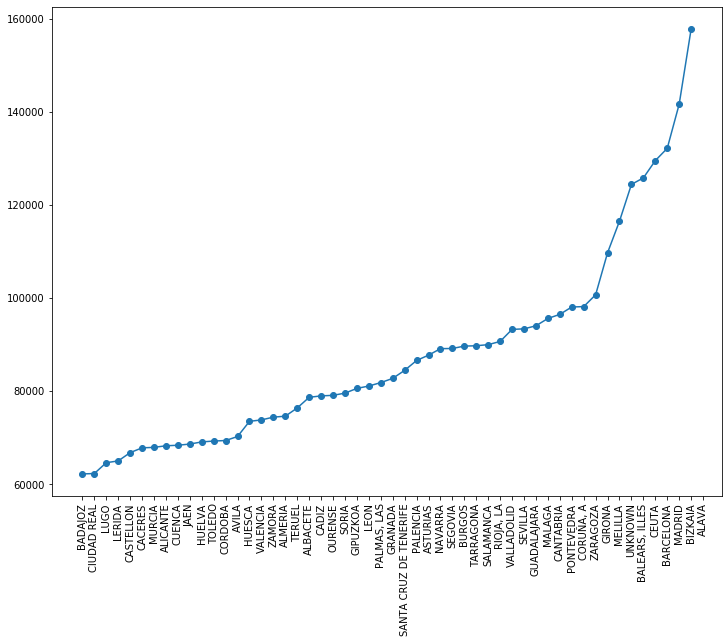

In [41]:
grouped = grouped.sort_values(by='income')

plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.plot(grouped.adress_txt, grouped.income, 'o-', label='income')
plt.xticks(rotation=90)
plt.show()

In [42]:
train[['age', 'new_person_flg', 'valid_month', 'primary_flg', 'country_flg', 'country_birth_flg', 'spouse_flg',
       'dead_flg', 'main_adress_flg', 'sleep_flg', 'income', 'saving_flg', 'guarantees_flg', 'current_flg',
       'derivative_flg', 'payroll1_flg', 'junior_flg', 'mas_particular_flg', 'particular_flg','particular_plus_flg', 
       'short_deposit_flg', 'medium_deposit_flg', 'long_deposit_flg', 'e-account_flg', 'funds_flg', 'mortgage_flg', 
       'pension1_flg', 'loan_flg', 'taxe_flg', 'credit_card_flg', 'securities_flg', 'home_account_flg', 
       'payroll2_flg', 'pension2_flg', 'direct_debit_flg']].describe()

,age,new_person_flg,valid_month,primary_flg,country_flg,country_birth_flg,spouse_flg,dead_flg,main_adress_flg,sleep_flg,...,mortgage_flg,pension1_flg,loan_flg,taxe_flg,credit_card_flg,securities_flg,home_account_flg,payroll2_flg,pension2_flg,direct_debit_flg
count,618439.000000,618439.000000,618439.000000,618439.000000,618439.000000,618439.000000,87.000000,618439.000000,618439.0,618439.000000,...,618439.000000,618439.000000,618439.000000,618439.000000,618439.000000,618439.000000,618439.000000,618394.000000,618394.000000,618439.000000
mean,40.483893,0.000249,80.313083,1.116629,0.994053,0.043668,0.011494,0.002563,1.0,0.537804,...,0.008017,0.011988,0.003363,0.059176,0.057437,0.032674,0.005212,0.062945,0.069941,0.153952
std,17.062837,0.015778,1799.645676,3.378768,0.076889,0.204356,0.107211,0.050560,0.0,0.498569,...,0.089178,0.108833,0.057896,0.235955,0.232675,0.177783,0.072002,0.242865,0.255048,0.360903
min,2.000000,0.000000,-999999.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,24.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,55.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,0.000000,141.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,116.000000,1.000000,246.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
#ВЕЛИКАЯ ТАБЛИЦА ФИЧЕЙ
feature_list = train[
      ['employee_index', 'sex', 'age', 'new_person_flg', 'valid_month', 'person_status', 'person_type', 'primary_flg',
       'country_flg', 'country_birth_flg',
       'dead_flg', 'main_adress_flg', 'sleep_flg', 'income', 'vip_flg', 'saving_flg', 'guarantees_flg',
       'current_flg',
       'derivative_flg', 'payroll1_flg', 'junior_flg', 'mas_particular_flg', 'particular_flg','particular_plus_flg', 
       'short_deposit_flg', 'medium_deposit_flg', 'long_deposit_flg', 'e-account_flg', 'funds_flg', 'mortgage_flg', 
       'pension1_flg', 'loan_flg', 'taxe_flg', 'credit_card_flg', 'securities_flg', 'home_account_flg', 
       'direct_debit_flg']]

In [44]:
flg_feature_list = train[
      ['person_id', 'saving_flg', 'guarantees_flg', 'current_flg',
       'derivative_flg', 'payroll1_flg', 'junior_flg', 'mas_particular_flg', 'particular_flg','particular_plus_flg', 
       'short_deposit_flg', 'medium_deposit_flg', 'long_deposit_flg', 'e-account_flg', 'funds_flg', 'mortgage_flg', 
       'pension1_flg', 'loan_flg', 'taxe_flg', 'credit_card_flg', 'securities_flg', 'home_account_flg', 
       'direct_debit_flg']]

тут будет мясо

In [45]:
count_dict = {}
for col_name in list(flg_feature_list.columns):
    if col_name != 'person_id':
        count_dict[col_name] = np.sum(train[col_name].astype('float64'))
        
top_products = sorted(count_dict, key=count_dict.get, reverse=True)

In [46]:
top_products #список продуктов по убыванию популярности

['current_flg',
 'particular_flg',
 'direct_debit_flg',
 'e-account_flg',
 'payroll1_flg',
 'taxe_flg',
 'particular_plus_flg',
 'long_deposit_flg',
 'credit_card_flg',
 'securities_flg',
 'funds_flg',
 'mas_particular_flg',
 'junior_flg',
 'pension1_flg',
 'mortgage_flg',
 'home_account_flg',
 'loan_flg',
 'medium_deposit_flg',
 'short_deposit_flg',
 'derivative_flg',
 'saving_flg',
 'guarantees_flg']

In [71]:
submission = submission.merge(train, on='person_id', how='left')

In [77]:
submission.head()

,person_id,added_products,date_x,employee_index_x,country_x,sex_x,age_x,activation_dttm_x,new_person_flg_x,valid_month_x,...,mortgage_flg,pension1_flg,loan_flg,taxe_flg,credit_card_flg,securities_flg,home_account_flg,payroll2_flg,pension2_flg,direct_debit_flg
0,15889,ind_tjcr_fin_ult1,2016-06-28 00:00:00,3.0,ES,1.0,56.0,1995-01-16 00:00:00,0.0,256.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,15890,ind_tjcr_fin_ult1,2016-06-28 00:00:00,1.0,ES,1.0,63.0,1995-01-16 00:00:00,0.0,257.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2,15892,ind_tjcr_fin_ult1,2016-06-28 00:00:00,3.0,ES,0.0,62.0,1995-01-16 00:00:00,0.0,257.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
3,15893,ind_tjcr_fin_ult1,2016-06-28 00:00:00,4.0,ES,1.0,63.0,1997-10-03 00:00:00,0.0,257.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,15894,ind_tjcr_fin_ult1,2016-06-28 00:00:00,1.0,ES,1.0,60.0,1995-01-16 00:00:00,0.0,257.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [73]:
submission.fillna(0, inplace=True)

In [74]:
answer = []
for ind, row in submission.iterrows():
    cust_id = row['person_id']
    top7_products = [] 
    for product in top_products:
        if int(row[product]) == 0:
            top7_products.append(str(product))
            if len(top7_products) == 7:
                break
    answer.append([cust_id, ' '.join(top7_products)])
    #writer.writerow([cust_id, " ".join(top7_products)])

In [75]:
answer = pd.DataFrame(answer)
answer.columns = ['ncodpers', 'added_products']
answer.head()

,ncodpers,added_products
0,15889,particular_flg direct_debit_flg e-account_flg ...
1,15890,current_flg particular_flg taxe_flg long_depos...
2,15892,current_flg particular_flg particular_plus_flg...
3,15893,current_flg particular_flg direct_debit_flg e-...
4,15894,particular_flg particular_plus_flg funds_flg m...


In [78]:
answer.to_csv('btb_answer.csv', index=False)

In [700]:
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

In [887]:
models = {}
model_preds = {}
id_preds = defaultdict(list)
ids = test['person_id'].values

for c in flg_feature_list:
    print(c)
    y_train = train[c]
    x_train = feature_list.drop(flg_feature_list, 1)

    clf = LogisticRegression()
    clf.fit(x_train, y_train)

    # predict model with the most recent data

    x_train2 = test[feature_list.drop(flg_feature_list, 1).columns]
    p_train = clf.predict_proba(x_train2)[:,1]
    p_train2 = clf.predict_proba(x_train)[:,1]

    models[c] = clf
    model_preds[c] = p_train

    for id, p in zip(ids, p_train):
        id_preds[id].append(p)

saving_flg
guarantees_flg
current_flg
derivative_flg
payroll1_flg
junior_flg
mas_particular_flg
particular_flg
particular_plus_flg
short_deposit_flg
medium_deposit_flg
long_deposit_flg
e-account_flg
funds_flg
mortgage_flg
pension1_flg
loan_flg
taxe_flg
credit_card_flg
securities_flg
home_account_flg
direct_debit_flg


In [923]:
already_active = {}
for row in train[list(flg_feature_list.columns)+['person_id']].values:
    row = list(row)
    id = row.pop(0)
    active = [c[0] for c in zip(tuple(flg_feature_list), row) if c[1] > 0]
    already_active[id] = active

KeyError: 15889

In [924]:
# add 7 products(that user don't have yet), higher probability first -> train_pred   
train_preds = {}
for id, p in id_preds.items():
    # Here be dragons
    preds = [i[0] for i in sorted([i for i in zip(tuple(flg_feature_list), p) if i[0] not in already_active[id]],
                                  key=lambda i:i [1], 
                                  reverse=True)[:7]]
    train_preds[id] = preds
    
test_preds = []
for row in submission.values:
    id = row[0]
    p = train_preds[id]
    test_preds.append(' '.join(p))

KeyError: 15889

In [ ]:
sample['added_products'] = test_preds

In [901]:
for i in flg_feature_list.columns:
    flg_feature_list[i] = pd.to_numeric(flg_feature_list[i], errors='coerce') 
    print(flg_feature_list[i].unique())

AttributeError: 'Series' object has no attribute 'type'